## Хомутов Евгений Васильевич, МСКМ-191
# Вычислительная геномика

In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика.

В качестве начального распределения возьмем предельное распределение. Решая систему уравнений и нормировочное уравнение:
$$
0.95p_1+ 0.05p_2 = p_1
$$
$$
0.01p_1+ 0.9p_2 = p_2
$$
$$
p_1 + p_2 = 1 
$$
получаем, что искомые вероятности равны (2/3;1/3)

In [2]:
class Croupier():
    def __init__(self):
        print('Croupier init')
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': [0.95,0.05], # to F, to U
            'U': [0.1,0.9] # to F, to U
        }
        
        self.startProbability = [2/3,1/3]

        self.currentState = np.random.choice(self.states, p =self.startProbability)
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }


    def changeDice(self):
        self.currentState = np.random.choice(self.states,p=self.transitionsProbability[self.currentState])

    def roll(self):
        return np.random.choice(self.diceValues, p=self.diceValueProbability[self.currentState]), self.currentState

    def __call__(self):
        self.changeDice()
        return self.roll()

In [3]:
casino = Croupier()
for i in range(10):
    print(casino())

Croupier init
(3, 'F')
(6, 'U')
(5, 'F')
(4, 'F')
(5, 'F')
(5, 'F')
(4, 'F')
(4, 'F')
(4, 'F')
(1, 'F')


Сгенерируем датасеты размером 300, 1 000 и 10 000

In [4]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

Croupier init


In [5]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

Croupier init


In [6]:
dataset10000 = []
dataset10000Labels = []

casino = Croupier()

for i in range(10000):
    data, label = casino()
    dataset10000.append(data)
    dataset10000Labels.append(label)

Croupier init


Ноль соответсвует честной кости, единица - нечестной.

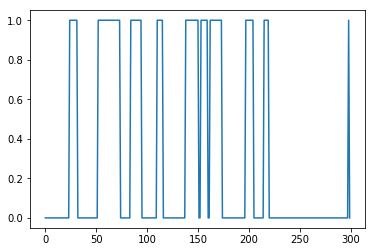

In [7]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

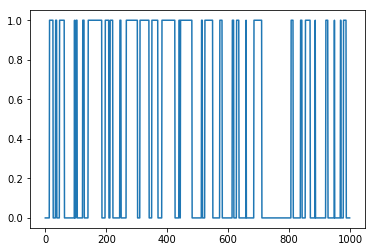

In [8]:
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
plt.plot(lab1000)

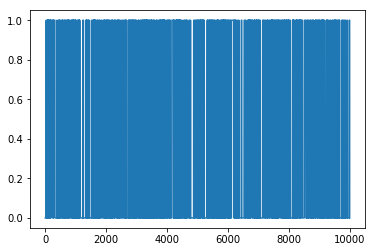

In [9]:
lab10000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
plt.plot(lab10000)

Посчитаем количество раз, когда использоволась какая кость для 10 000 раз

In [10]:
from collections import Counter
Counter(dataset10000Labels)

Counter({'F': 6471, 'U': 3529})

Все хорошо согласуется с предельным распределением, следовательно сплошная линия на графике для 10 000 ошибка изображения, но не моделирования

Определим базовый класс для алгоритмов, в котором будем хранить данные о нашей скрытой марковской цепи

In [11]:
class baseAlgo():
    def __init__(self, data):
        #print("BaseAlgo init")
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

## Алгоритм Витерби

Реализуем алгоритм Витерби

In [12]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        print('ViterbiAlgo init')
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

ViterbiAlgo init
RESULT: 0.76
Probability: 3.2043564710742755e-238


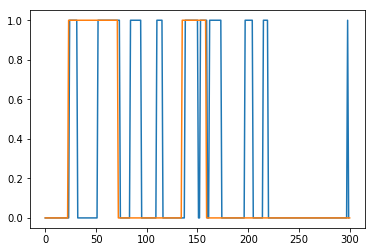

In [13]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

ViterbiAlgo init
RESULT: 0.699
Probability: 0.0


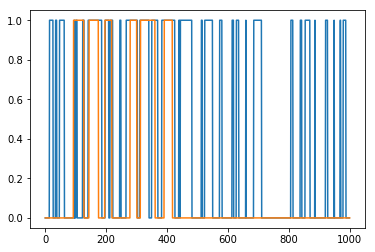

In [14]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

ViterbiAlgo init
RESULT: 0.655
Probability: 0.0


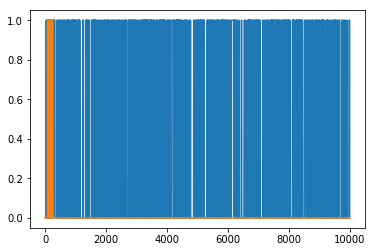

In [15]:
hackCasinoViterbi = algorithmViterbi(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

Из графиков икачетсва работы с 1000 и 10 000 экземпляров видно, что накапление машинной ошибки ведет к тому, что алгоритм уже не в состояние выдавать ненулевые значения. Чтобы избежать этого, перейдем в логарифмический масштаб

In [16]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [17]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.76
Probability: 3.204356471070827e-238


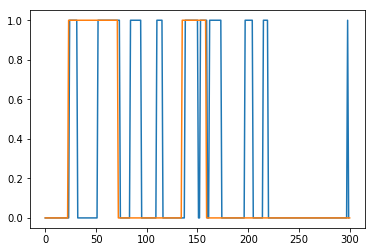

In [18]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.764
Probability: 3.204356471070827e-238


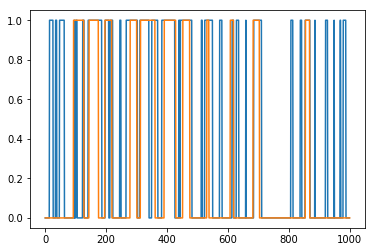

In [19]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.7905
Probability: 3.204356471070827e-238


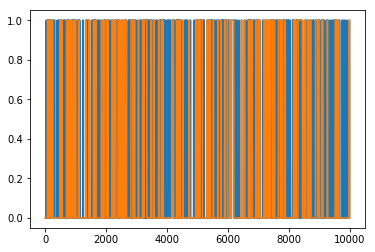

In [20]:
hackCasinoViterbi = algorithmViterbiLog(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab10000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

Использование логарифмического масштаба улучшило работы алгоритма, что видно как гарфически так и численно, в сравнение с правильными лейблами для костей.

## Алгорит прямого и обратного хода, апостериорное дешифрование

In [21]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        super().__init__(data)
        #print('Forward init')
        
        self.f = []
        self.pathProbability = None
    
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])

In [22]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        super().__init__(data)
        #print('Backward init')
        
        self.b = []
        self.pathProbabilityB = None
    
    def stepBackward(self, index):
        self.b.append([])
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbabilityB == None: self.initialization()
        return self.pathProbabilityB
    
    def initialization(self):
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbabilityB = sum(self.b[0])

In [23]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\n'.format(f,b))

FORWARD: 1.268953710916188e-229
BACKWARD: 1.3394691506585848e-228



Проверим, что все считается верно: перемножим f и b в каждом столбце

In [24]:
pprint.pprint([sum(f*np.array(b)) for f, b in zip(forwardHack.f, backwardHack.b)])

[1.268953710916207e-229,
 1.2689537109162069e-229,
 1.2689537109162069e-229,
 1.2689537109162067e-229,
 1.2689537109162069e-229,
 1.2689537109162067e-229,
 1.2689537109162067e-229,
 1.2689537109162065e-229,
 1.2689537109162067e-229,
 1.2689537109162065e-229,
 1.2689537109162061e-229,
 1.2689537109162061e-229,
 1.268953710916206e-229,
 1.2689537109162058e-229,
 1.2689537109162058e-229,
 1.2689537109162056e-229,
 1.2689537109162058e-229,
 1.2689537109162058e-229,
 1.2689537109162058e-229,
 1.2689537109162058e-229,
 1.2689537109162054e-229,
 1.2689537109162054e-229,
 1.2689537109162054e-229,
 1.2689537109162052e-229,
 1.2689537109162052e-229,
 1.268953710916205e-229,
 1.2689537109162052e-229,
 1.2689537109162052e-229,
 1.268953710916205e-229,
 1.268953710916205e-229,
 1.2689537109162049e-229,
 1.2689537109162047e-229,
 1.2689537109162045e-229,
 1.2689537109162047e-229,
 1.2689537109162047e-229,
 1.2689537109162047e-229,
 1.2689537109162049e-229,
 1.2689537109162047e-229,
 1.26895371091620

Так как на каждом шаге у нас выдается одна и таже величина, то прямой и обратный ход работfют корректно

In [25]:
class PosteriorDecoding(forwardAlgorithm, backwardAlgorithm):
    def __init__(self, data):
        super().__init__(data)
        # For decoding
        self.conditionalProbability = None
            
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        self.pathProbability = 0.0
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

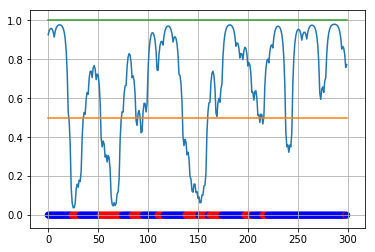

In [26]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


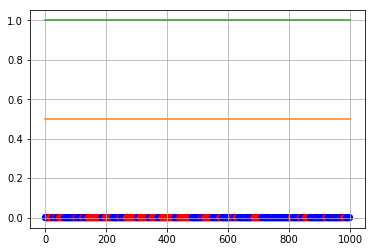

In [27]:
PosteriorHack = PosteriorDecoding(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


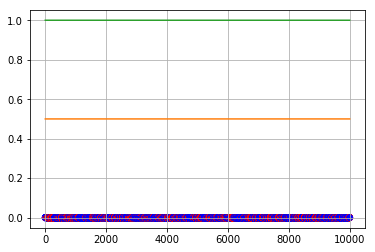

In [28]:
PosteriorHack = PosteriorDecoding(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Из-за потери машиной точности, графики на последовательностях 1000 и 10 000 построить не получилось. Чтобы исправить эту проблему применим масштабирование для алгоритма декодирования

In [29]:
class PosteriorDecodingScaled(PosteriorDecoding):
    def __init__(self, data):
        PosteriorDecoding.__init__(self,data)
        # For scaling
        self.scaledConstF = []
        self.scaledConstB = []
        
    def stepForward(self, index):
        super().stepForward(index)
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        
    def stepBackward(self, index):
        super().stepBackward(index)
        
        self.scaledConstB.append(max(self.b[-1]))
        self.b[-1] = self.b[-1]/self.scaledConstB[-1]        
        
    def initialization(self): # Тоже следует красиво переписать
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        self.scaledConstB.append(1)
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        self.scaledConstB = self.scaledConstB[::-1]
        for i in range(self.L):
            # трюк чтобы не терять точность
            ###
            coeff = 1
            for backCoeff, forwardCoeff in zip(self.scaledConstB[i:],self.scaledConstF[i+1:]):
                coeff *= backCoeff/forwardCoeff
                
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability * coeff
            self.conditionalProbability.append(conProb)

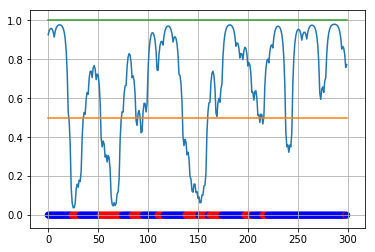

In [30]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)

ax.plot([.5 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

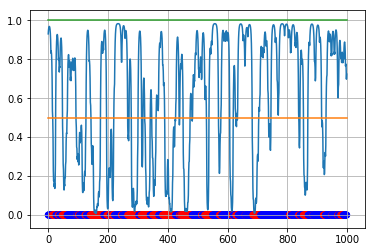

In [31]:
PosteriorHack = PosteriorDecodingScaled(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

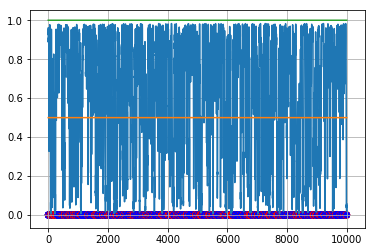

In [32]:
PosteriorHack = PosteriorDecodingScaled(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

## Алгоритм Баума-Велша

Реализуем класс с параметрами, которые не совпадают с параметрами используемой марковской цепи.

In [33]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6,1/6,1/6,1/6,1/6,1/6],
            'U': [1/10,1/10,1/10,1/10,1/10,1/2]
        }

In [34]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.8,0.2]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [2/12,2/12,2/12,3/12,2/12,1/12],
            'U': [2/20,4/20,1/20,3/20,2/20,8/20]
        }

In [35]:
class BaumWelchTrainig(parametrs, PosteriorDecoding):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.f = []
            self.b = []
            self.pathProbability = .0
            self.initialization()
            # Change paramets
            self.changeParametrs()
            
            currentLog = self.logLikelihood()
            print("LOG: {}".format(currentLog))
            
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]#/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] += self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }

        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)
        
# Без фиксации 
trainig = BaumWelchTrainig(dataset300)
trainig()

LOG: -532.1855183280364
LOG: -524.9279011458167
LOG: -523.9150754113136
LOG: -523.2136167888743
LOG: -522.6937718229375
LOG: -522.3188288509343
LOG: -522.0650748721569
LOG: -521.9017248860215
LOG: -521.7970344338877
LOG: -521.7263133455616
Log doesnot change: stop in 9 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.79213545, 0.20786455]), 'U': "
 'array([0.08797921, 0.91202079])}')
("diceValueProbability: {'F': [0.2909988455358245, 0.1381504948057033, "
 '0.18965779396647778, 0.0842970577513613, 0.20545565971344928, '
 "0.09144014822718385], 'U': [0.05891955944071429, 0.16964648193621631, "
 '0.12768623076080213, 0.18861760189035123, 0.10149157250456695, '
 '0.3536385534673491]}')


In [36]:
dataset300_10 = []

casino = Croupier()
for j in range(10):
    dataset300_10.append([])
    for i in range(300):
        data, _ = casino()
        dataset300_10[j].append(data)

Croupier init


In [37]:
class parametrsMany(parametrs):
    def __init__(self, data):
        super().__init__(data)
        print('Special parametrs init')
        self.number = len(data)
        self.L = len(data[0])

In [38]:
class specialForward(parametrsMany):
    def __init__(self, data):
        super().__init__(data)
        
    def initializationForward(self):
        self.f = []
        self.pathProbability = []
        for J in range(self.number):
            forward = forwardAlgorithm(self.data[J])
            
            forward.diceValueProbability = self.diceValueProbability
            forward.transitionsProbability = self.transitionsProbability
            
            pathProbability = forward()
            f = forward.f
            self.f.append(f)
            self.pathProbability.append(pathProbability)

In [39]:
class specialBackward(parametrsMany):
    def __init__(self, data):
        super().__init__(data)
        
    def initializationBackward(self):
        self.b = []
        for J in range(self.number):
            backward = backwardAlgorithm(self.data[J])
            
            backward.diceValueProbability = self.diceValueProbability
            backward.transitionsProbability = self.transitionsProbability
            
            pathProbability = backward()
            b = backward.b
            self.b.append(b)

In [40]:
class BaumWelchTrainigMany(specialForward, specialBackward):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            
            self.initializationForward()
            self.initializationBackward()
            
            currentLog = self.logLikelihood()
            # Change paramets
            print(currentLog)
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
            self.changeParametrs()
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return sum(np.log(self.pathProbability))
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                A[fromState][newState] = 0.0
                for J in range(self.number):
                    sum_step = [
                        self.f[J][i][fromI] * self.b[J][i+1][newI] * 
                        self.diceValueProbability[newState][self.data[J][i+1] - 1] 
                        for i in range(self.L-1)
                    ]
                    probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability[J]
                    A[fromState][newState] += probability
                #A[fromState][newState] /= self.number
        # Add B
        B = {}
        
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for J in range(self.number):
                for i,value in enumerate(self.data[J]):
                    B[state][value - 1] += self.f[J][i][index] * self.b[J][i][index] #/ self.number
        
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        # Выводить вероятность последовательности
        
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [41]:
trainig = BaumWelchTrainigMany(dataset300_10)
trainig()

Special parametrs init
-5356.090522438145
-5272.595275559441
-5273.594760638392
-5277.009040701567
-5278.162125515106
-5278.93212218888
-5279.228649619688
-5279.145938342781
Log doesnot change: stop in 7 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.88141557, 0.11858443]), 'U': "
 'array([0.1923475, 0.8076525])}')
("diceValueProbability: {'F': [0.19189755126846708, 0.15949159557489107, "
 '0.2440475349575766, 0.1544715739870625, 0.13682793019313685, '
 "0.11326381401886598], 'U': [0.07461679535425372, 0.1124522191933882, "
 '0.04909548669551463, 0.08730105956378093, 0.11234032567104568, '
 '0.5641941135220168]}')


Результаты занятны: в этом случае алгоритм счтает что вероятность перехода на первый кубик составляет 10 процентов, и первый кубик используется только для генерации одного числа - в этом случае 3.